<a href="https://colab.research.google.com/github/JoseTomas-TomTom/Parallel-DQN-for-Autonomous-Lane-Keeping/blob/main/Main_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 60.7     |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 1260     |
|    time_elapsed     | 37       |
|    total_timesteps  | 47272    |
| train/              |          |
|    learning_rate    | 0.000265 |
|    loss             | 0.00367  |
|    n_updates        | 1165     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 60.6     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 1260     |
|    time_elapsed     | 37       |
|    total_timesteps  | 47600    |
| train/              |          |
|   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Saved: lane_keeping_split_demo.mp4


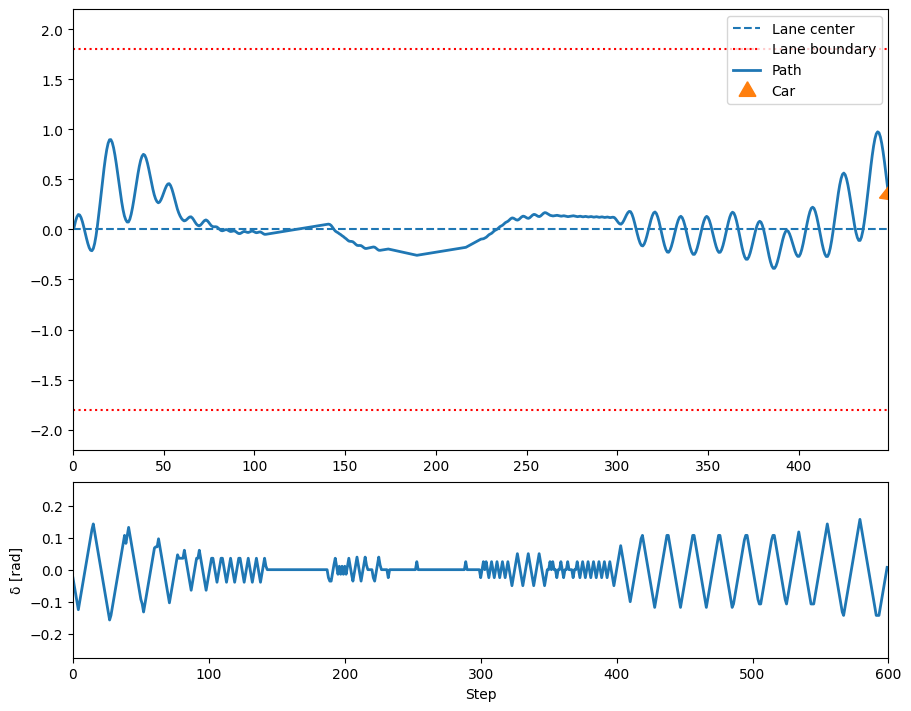

In [3]:
!pip -q install gymnasium==0.29.1 stable-baselines3==2.3.2 matplotlib numpy

# ===== Imports =====
import os, math, numpy as np, matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy

# ===== Environment: lane preview + noise + safety + curriculum =====
class LaneKeepingEnv(gym.Env):
    """
    Discrete steering (DQN) lane keeping with:
    - Squared penalties (y, psi, y_dot) + soft boundary penalty + progress bonus
    - Lane curvature (now + preview) in observation
    - Sensor noise, randomized lane shapes, and light curriculum on curvature amplitude
    - Safety layer: steering clamp + rate limit
    """
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super().__init__()
        # Dynamics
        self.dt = 0.05          # s
        self.v = 15.0           # m/s
        self.wheelbase = 2.7    # m
        self.max_delta = 0.25   # rad (steer)
        self.lane_half_width = 1.8
        self.max_steps = 600

        # Discrete actions
        self.n_actions = 15
        self.action_space = spaces.Discrete(self.n_actions)
        self.action_map = np.linspace(-self.max_delta, self.max_delta, self.n_actions)

        # Lane (curvature) + noise
        self.curv_amp_range = (0.0, 0.005)        # rad/m
        self.curv_freq_range = (0.0005, 0.002)    # cycles per meter
        self.lat_noise_std = 0.005                # m
        self.psi_noise_std = 0.001                # rad
        self.preview_dist = 15.0                  # m

        # Observation: [y, psi, x, k_now, k_preview]
        high = np.array([10.0, np.pi, 1e6, 0.02, 0.02], dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        # For curriculum & safety
        self.global_steps = 0
        self.last_delta = 0.0
        self.reset()

    # ----- Lane model -----
    def lane_curvature(self, x):
        return self.k_amp * np.sin(self.k_freq * x + self.k_phase)

    def _get_obs(self):
        y, psi, x = self.state
        k_now = self.lane_curvature(x)
        k_prev = self.lane_curvature(x + self.preview_dist)
        # sensor noise
        y_n = y + self.np_random.normal(0, self.lat_noise_std)
        psi_n = psi + self.np_random.normal(0, self.psi_noise_std)
        return np.array([y_n, psi_n, x, k_now, k_prev], dtype=np.float32)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        # Light curriculum on curvature amplitude over training time
        max_amp = float(np.interp(self.global_steps, [0, 1_000_000], [0.0, 0.008]))
        a_lo, a_hi = self.curv_amp_range
        self.k_amp = self.np_random.uniform(a_lo, max(a_hi, max_amp))
        self.k_freq = self.np_random.uniform(*self.curv_freq_range)
        self.k_phase = self.np_random.uniform(0, 2*np.pi)

        # Initial state
        y0   = self.np_random.uniform(-0.5, 0.5)
        psi0 = self.np_random.uniform(-0.1, 0.1)
        x0   = 0.0
        self.state = np.array([y0, psi0, x0], dtype=np.float32)

        self.steps = 0
        self.last_delta = 0.0
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        # Map action -> steering command
        cmd = float(self.action_map[int(action)])

        # Safety layer: clamp and rate-limit
        cmd = np.clip(cmd, -self.max_delta, self.max_delta)
        max_rate = 0.5  # rad/s
        cmd = np.clip(cmd, self.last_delta - max_rate*self.dt, self.last_delta + max_rate*self.dt)

        # Kinematics
        y, psi, x = self.state
        psi += (self.v / self.wheelbase) * math.tan(cmd) * self.dt
        x   += self.v * math.cos(psi) * self.dt
        y   += self.v * math.sin(psi) * self.dt
        self.state = np.array([y, psi, x], dtype=np.float32)

        self.global_steps += 1
        self.steps += 1

        # Reward terms
        y_dot = self.v * math.sin(psi)
        lambda_y, lambda_psi, lambda_ydot = 0.8, 0.25, 0.08
        lambda_delta, lambda_dchange = 0.002, 0.05
        d_change = cmd - self.last_delta

        # Soft boundary penalty
        margin = 0.3
        dist_to_edge = self.lane_half_width - abs(y)
        edge_pen = 0.0 if dist_to_edge > margin else 0.5 * (margin - dist_to_edge) / margin  # 0..0.5

        # Progress bonus
        progress_bonus = 0.001 * (self.v * math.cos(psi) * self.dt)

        reward = (
            1.0
            - lambda_y*(y**2)
            - lambda_psi*(psi**2)
            - lambda_ydot*(y_dot**2)
            - lambda_delta*(cmd**2)
            - lambda_dchange*(d_change**2)
            - edge_pen
            + progress_bonus
        )

        self.last_delta = cmd

        # Termination
        terminated = (abs(y) > self.lane_half_width + 0.05) or (abs(psi) > math.pi/2)
        truncated  = self.steps >= self.max_steps

        info = {"y": y, "psi": psi, "x": x, "delta": cmd}
        return self._get_obs(), float(reward), terminated, truncated, info

# ===== Vec env builders (with Monitor for stats) =====
def make_env(seed_offset=0):
    def _init():
        env = LaneKeepingEnv()
        env = Monitor(env)  # episodic stats for TensorBoard
        env.reset(seed=seed_offset)
        return env
    return _init

N_ENVS = 8
train_env = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Temporary eval env before saving stats (we’ll reload later)
eval_env = DummyVecEnv([make_env(10_000)])
eval_env = VecNormalize(eval_env, training=False, norm_obs=True, norm_reward=False, clip_obs=10.0)
eval_env.obs_rms = train_env.obs_rms

# ===== Callbacks (Eval + Checkpoints) =====
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs_dqn/",
    log_path="./logs_dqn/",
    eval_freq=10_000 // N_ENVS,
    deterministic=True,
    render=False,
)
ckpt_callback = CheckpointCallback(
    save_freq=50_000 // N_ENVS,
    save_path="./logs_dqn/",
    name_prefix="dqn_lane",
)

# ===== DQN config =====
def lr_schedule(progress_remaining):
    return 3e-4 * progress_remaining  # linear decay

policy_kwargs = dict(net_arch=[256, 256])

model = DQN(
    "MlpPolicy",
    train_env,
    learning_rate=lr_schedule,
    gamma=0.99,
    buffer_size=300_000,
    learning_starts=10_000,
    batch_size=256,
    tau=0.005,
    train_freq=(4, "step"),
    gradient_steps=1,
    target_update_interval=8_000,
    exploration_fraction=0.35,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.02,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log="./tb_dqn/",
)

# ===== Train =====
TIMESTEPS = 400_000
model.learn(total_timesteps=TIMESTEPS, callback=[eval_callback, ckpt_callback])
model.save("dqn_lane_keep")
train_env.save("vecnormalize_train.pkl")  # save normalization for clean eval

# ===== Proper eval: rebuild env and load VecNormalize stats =====
eval_env = DummyVecEnv([make_env(42)])
eval_env = VecNormalize.load("vecnormalize_train.pkl", eval_env)
eval_env.training = False
eval_env.norm_reward = False

best_path = "./logs_dqn/best_model.zip"
model_path = best_path if os.path.exists(best_path) else "dqn_lane_keep"
model = DQN.load(model_path, env=eval_env)

mean_r, std_r = evaluate_policy(model, eval_env, n_eval_episodes=5, deterministic=True)
print(f"Eval mean reward: {mean_r:.3f} ± {std_r:.3f}")

# ===== Rollout for metrics + animation (correct vec handling) =====
obs = eval_env.reset()
done = np.array([False])
xs, ys, deltas, psis = [], [], [], []

while not bool(done[0]):
    action, _ = model.predict(obs, deterministic=True)
    obs, r, done, infos = eval_env.step(action)
    info = infos[0]
    xs.append(info["x"]); ys.append(info["y"]); deltas.append(info["delta"]); psis.append(info["psi"])

if len(xs) == 0:
    xs, ys, deltas, psis = [0.0], [0.0], [0.0], [0.0]

def compute_metrics(xs, ys):
    xs = np.asarray(xs); ys = np.asarray(ys)
    center_rmse = float(np.sqrt(np.mean(np.square(ys))))
    in_lane = float(np.mean(np.abs(ys) <= 1.8))
    return {"center_rmse": center_rmse, "pct_in_lane": in_lane}

metrics = compute_metrics(xs, ys)
print("Metrics:", metrics)

# ===== Split-screen animation =====
import matplotlib.animation as animation
from IPython.display import HTML

fig, (ax_traj, ax_steer) = plt.subplots(
    2, 1, figsize=(9, 7), gridspec_kw={'height_ratios':[2.5,1]}, constrained_layout=True
)

x_min, x_max = 0.0, max(xs) if len(xs) > 0 else 10.0
ax_traj.set_xlim(x_min, x_max)
ax_traj.set_ylim(-2.2, 2.2)
ax_traj.axhline(0.0, ls="--", label="Lane center")
ax_traj.axhline(+1.8, ls=":", color="r", label="Lane boundary")
ax_traj.axhline(-1.8, ls=":", color="r")
traj_path, = ax_traj.plot([], [], lw=2, label="Path")
car, = ax_traj.plot([], [], marker=(3, 0, 0), markersize=14, linestyle="None", label="Car")
ax_traj.legend(loc="upper right")

def set_car_marker(line, psi_rad):
    line.set_marker((3, 0, np.degrees(psi_rad)))

ax_steer.set_xlim(0, len(deltas))
delta_lim = max(0.25, float(np.max(np.abs(deltas))))
ax_steer.set_ylim(-delta_lim*1.1, delta_lim*1.1)
steer_line, = ax_steer.plot([], [], lw=2)
ax_steer.set_xlabel("Step"); ax_steer.set_ylabel("δ [rad]")

def init():
    traj_path.set_data([], [])
    car.set_data([], [])
    set_car_marker(car, 0.0)
    steer_line.set_data([], [])
    return traj_path, car, steer_line

def update(i):
    traj_path.set_data(xs[:i+1], ys[:i+1])
    car.set_data([xs[i]], [ys[i]])
    set_car_marker(car, psis[i])
    steer_line.set_data(range(i+1), deltas[:i+1])
    return traj_path, car, steer_line

frames = len(xs)
interval_ms = 40
ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init, interval=interval_ms, blit=True)
ani.save("lane_keeping_split_demo.mp4", writer="ffmpeg", fps=int(1000/interval_ms))
print("✅ Saved: lane_keeping_split_demo.mp4")

HTML('<video controls width="720" src="lane_keeping_split_demo.mp4"></video>')


In [4]:
# ✅ Show the optimizer object used by your DQN model
print(model.policy.optimizer)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.5024000000000002e-05
    maximize: False
    weight_decay: 0
)
